Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
print(tf.__version__)

2.3.1


In [95]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [96]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('gdrive/My Drive/CNN_Assignment_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/')
data_dir_test = pathlib.Path('gdrive/My Drive/CNN_Assignment_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [97]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [98]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [99]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, labels='inferred', batch_size= batch_size, 
           image_size=(img_height,img_width), shuffle=True, seed=123, 
           validation_split=0.2, subset="training",interpolation='bilinear', follow_links=False)

Found 6239 files belonging to 9 classes.
Using 4992 files for training.


In [100]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, labels='inferred', batch_size= batch_size, 
           image_size=(img_height,img_width), shuffle=True, seed=123, 
           validation_split=0.2, subset="validation",interpolation='bilinear', follow_links=False)

Found 6239 files belonging to 9 classes.
Using 1247 files for validation.


In [101]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

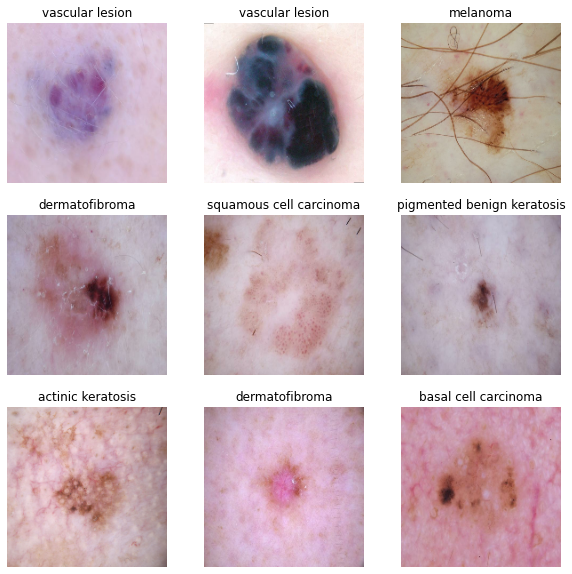

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [103]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [104]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [105]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [106]:
### Your code goes here
num_classes = 9

model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))])
# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu'))
# second conv layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# First Pooling Layer
model.add(MaxPooling2D(pool_size=(2, 2)))
# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
# softmax layer
model.add(Dense(num_classes, activation='softmax'))
                   

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [107]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [108]:
# View the summary of all layers
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 176, 176, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 88, 88, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 495616)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               63438976  
_________________________________________________________________
dense_11 (Dense)             (None, 9)                

### Train the model

In [109]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
156/156 [==============================] - 42s 108ms/step - loss: 5.1074 - accuracy: 0.2515 - val_loss: 1.5276 - val_accuracy: 0.4306
Epoch 2/20
156/156 [==============================] - 10s 67ms/step - loss: 1.4192 - accuracy: 0.4868 - val_loss: 1.2860 - val_accuracy: 0.5397
Epoch 3/20
156/156 [==============================] - 10s 67ms/step - loss: 1.0301 - accuracy: 0.6363 - val_loss: 1.2090 - val_accuracy: 0.6006
Epoch 4/20
156/156 [==============================] - 10s 67ms/step - loss: 0.7828 - accuracy: 0.7443 - val_loss: 1.0832 - val_accuracy: 0.6447
Epoch 5/20
156/156 [==============================] - 10s 66ms/step - loss: 0.6181 - accuracy: 0.7938 - val_loss: 1.1761 - val_accuracy: 0.6632
Epoch 6/20
156/156 [==============================] - 10s 66ms/step - loss: 0.4496 - accuracy: 0.8528 - val_loss: 1.2469 - val_accuracy: 0.6784
Epoch 7/20
156/156 [==============================] - 10s 66ms/step - loss: 0.3245 - accuracy: 0.9007 - val_loss: 1.1477 - val_accuracy

### Visualizing training results

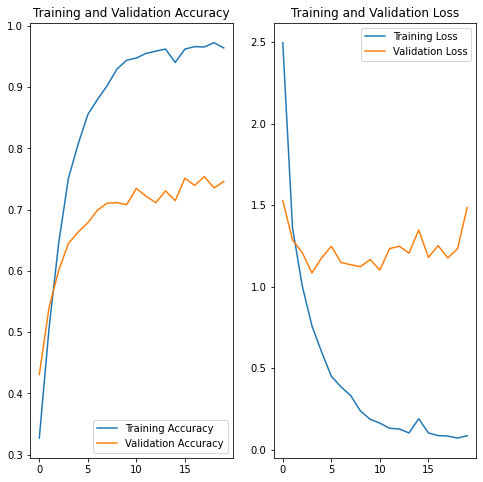

In [110]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
###The model seems to have overfit the training data. It is clearly evident from the graphs shown above that the training accuracy has gone upto 95% while validation accuracy got stagnant at around 54%.

###Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

###Another technique to reduce overfitting is to introduce Dropout to the network, a form of regularization.When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer. 

In [111]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

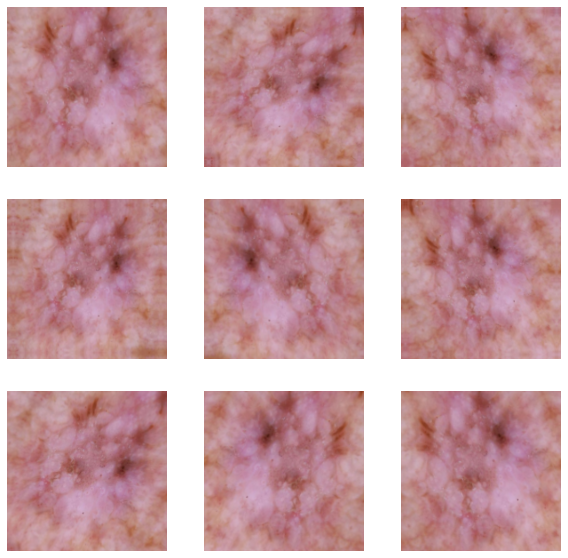

In [112]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [113]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [114]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 45, 45, 64)       

### Training the model

In [115]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
156/156 [==============================] - 5s 27ms/step - loss: 2.1209 - accuracy: 0.2278 - val_loss: 1.4908 - val_accuracy: 0.4579
Epoch 2/20
156/156 [==============================] - 4s 26ms/step - loss: 1.4669 - accuracy: 0.4424 - val_loss: 1.3612 - val_accuracy: 0.4924
Epoch 3/20
156/156 [==============================] - 4s 26ms/step - loss: 1.3381 - accuracy: 0.4960 - val_loss: 1.2743 - val_accuracy: 0.5269
Epoch 4/20
156/156 [==============================] - 4s 26ms/step - loss: 1.2443 - accuracy: 0.5145 - val_loss: 1.2032 - val_accuracy: 0.5533
Epoch 5/20
156/156 [==============================] - 4s 26ms/step - loss: 1.2130 - accuracy: 0.5326 - val_loss: 1.1107 - val_accuracy: 0.5638
Epoch 6/20
156/156 [==============================] - 4s 26ms/step - loss: 1.1545 - accuracy: 0.5654 - val_loss: 1.1811 - val_accuracy: 0.5453
Epoch 7/20
156/156 [==============================] - 4s 26ms/step - loss: 1.0792 - accuracy: 0.5879 - val_loss: 1.0527 - val_accuracy: 0.5982

### Visualizing the results

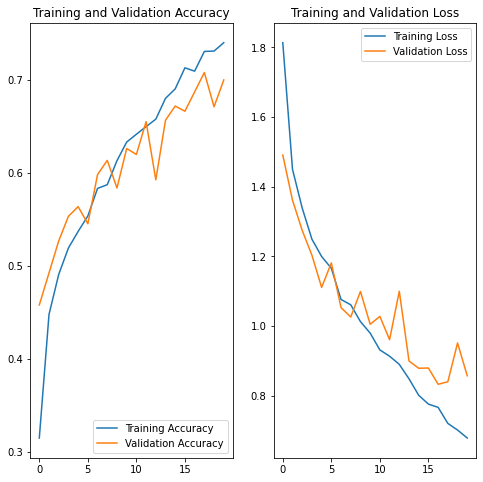

In [116]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

After data augmentation strategy and dropouts regularization, we found not much difference between the training and validation accuracy. Hence the model is not overfitted. However still the model accuracy is not very good.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [117]:
## Your code goes here.

for i in class_names:
  print(i)
  path1 = pathlib.Path('gdrive/My Drive/CNN_Assignment_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/' + i)
  print(len(list((path1.glob('*/*.jpg')))))




actinic keratosis
0
basal cell carcinoma
500
dermatofibroma
500
melanoma
500
nevus
500
pigmented benign keratosis
500
seborrheic keratosis
500
squamous cell carcinoma
500
vascular lesion
500


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [118]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [119]:
path_to_training_dataset= 'gdrive/My Drive/CNN_Assignment_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/CNN_Assignment_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6AD0B8DBE0>: 100%|██████████| 500/500 [00:18<00:00, 26.97 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/CNN_Assignment_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6ADC5A5668>: 100%|██████████| 500/500 [00:17<00:00, 28.25 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/CNN_Assignment_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6AD0DC7390>: 100%|██████████| 500/500 [00:18<00:00, 27.23 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/CNN_Assignment_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6ADC4A9940>: 100%|██████████| 500/500 [01:26<00:00,  5.79 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/CNN_Assignment_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6AD0E42630>: 100%|██████████| 500/500 [01:22<00:00,  6.07 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/CNN_Assignment_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6AE40BD470>: 100%|██████████| 500/500 [00:18<00:00, 27.21 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/CNN_Assignment_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6ADC287B70>: 100%|██████████| 500/500 [00:40<00:00, 12.32 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/CNN_Assignment_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6AD0C044A8>: 100%|██████████| 500/500 [00:18<00:00, 27.06 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6ADC444E80>:   0%|          | 1/500 [00:00<01:05,  7.63 Samples/s]

Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/CNN_Assignment_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6AD156C550>: 100%|██████████| 500/500 [00:18<00:00, 26.94 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [120]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

8500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [121]:
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['gdrive/My Drive/CNN_Assignment_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026040.jpg_4a675e95-c982-44df-9e04-8fa534abf1eb.jpg',
 'gdrive/My Drive/CNN_Assignment_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030730.jpg_7d603da1-5cce-4b32-bbd4-125b9172d65d.jpg',
 'gdrive/My Drive/CNN_Assignment_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028076.jpg_33515d70-9199-48f5-8158-51ecfc966dfb.jpg',
 'gdrive/My Drive/CNN_Assignment_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026625.jpg_46f3c5dd-a004-4876-8811-b93373510d6f.jpg',
 'gdrive/My Drive/CNN_Assignment_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic

In [122]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [123]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [124]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [125]:
df2['Label'].value_counts()

nevus                         1000
melanoma                      1000
vascular lesion               1000
basal cell carcinoma          1000
seborrheic keratosis          1000
pigmented benign keratosis    1000
dermatofibroma                1000
squamous cell carcinoma       1000
actinic keratosis              500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [126]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [127]:
data_dir_train="gdrive/My Drive/CNN_Assignment_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10739 files belonging to 9 classes.
Using 8592 files for training.


#### **Todo:** Create a validation dataset

In [128]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10739 files belonging to 9 classes.
Using 2147 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [129]:
## your code goes here
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))])
# first conv layer
model.add(Conv2D(16, kernel_size=(3, 3),activation='relu'))
# second conv layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
# First Pooling Layer
model.add(MaxPooling2D(pool_size=(2, 2)))
# third conv layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# Second Pooling Layer
model.add(MaxPooling2D(pool_size=(2, 2)))
# dropout
model.add(Dropout(0.2))
# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
# softmax layer
model.add(Dense(num_classes, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [130]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_7 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 178, 178, 16)      448       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 176, 176, 32)      4640      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 86, 86, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 43, 43, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 43, 43, 64)      

#### **Todo:**  Train your model

In [131]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
269/269 [==============================] - 67s 244ms/step - loss: 2.5541 - accuracy: 0.2469 - val_loss: 1.3656 - val_accuracy: 0.4965
Epoch 2/30
269/269 [==============================] - 66s 242ms/step - loss: 1.2958 - accuracy: 0.5236 - val_loss: 1.2610 - val_accuracy: 0.5328
Epoch 3/30
269/269 [==============================] - 66s 240ms/step - loss: 1.1027 - accuracy: 0.5949 - val_loss: 1.0969 - val_accuracy: 0.6204
Epoch 4/30
269/269 [==============================] - 65s 239ms/step - loss: 0.8135 - accuracy: 0.7082 - val_loss: 1.0410 - val_accuracy: 0.6223
Epoch 5/30
269/269 [==============================] - 65s 239ms/step - loss: 0.6746 - accuracy: 0.7674 - val_loss: 0.8137 - val_accuracy: 0.7354
Epoch 6/30
269/269 [==============================] - 66s 239ms/step - loss: 0.5005 - accuracy: 0.8271 - val_loss: 0.7474 - val_accuracy: 0.7988
Epoch 7/30
269/269 [==============================] - 66s 240ms/step - loss: 0.3570 - accuracy: 0.8798 - val_loss: 0.6709 - val_ac

#### **Todo:**  Visualize the model results

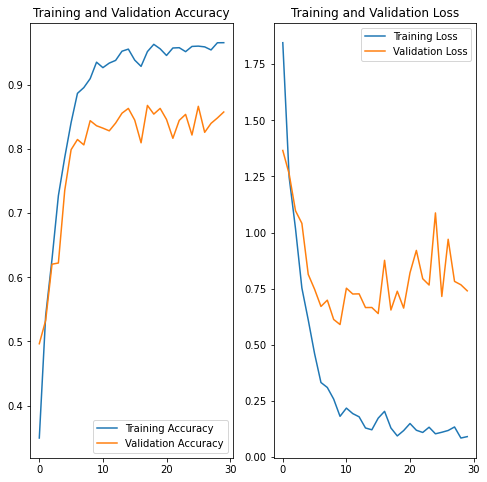

In [132]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [133]:
### The model training and validation accuracy has increased after increasing the sample size. However there is still sign of overfitting which could be regularized using increasing dropouts